# スパースガウス過程でロジスティック回帰をminibatchでやるための試作

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../lib")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy.spatial import distance_matrix
from scipy.stats import wishart

from util import logcosh, ratio_tanh_x

## 学習設定

In [4]:
data_seed = 20190908
n = 1000
sub_n = 400
M = 1
domain_X = (-10, 10)

true_func = lambda x: (x * np.sin(x)).sum(axis = 1)

## データ生成

In [5]:
np.random.seed(data_seed)

train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (n, M))
train_func = true_func(train_X)
train_prob = expit(train_func)
train_Y = np.random.binomial(n = 1, p = train_prob, size = n)

# 学習開始

## 学習設定

In [6]:
learning_seed = 20190909

iteration = 1000
theta1 = 1; theta2 = 1; theta3 = 0.0001
kronecker_delta = lambda x,y: np.exp(-distance_matrix(x,y)**2/(0.00001))
gauss_kernel = lambda x,y: theta1 * np.exp(-distance_matrix(x,y)**2/(theta2)) + theta3 * kronecker_delta(x,y)
gauss_kernel_diag = lambda x: theta1 * np.ones(len(x))  + theta3

used_kernel = gauss_kernel
used_kernel_diag = gauss_kernel_diag

step = 0.5
tol = 1e-7

## 部分データの選択

In [7]:
np.random.seed(learning_seed)
sub_train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (sub_n, M))
# sub_ind = np.random.permutation(n)[:sub_n]
# sub_train_X = train_X[sub_ind,:]

## 学習前の事前計算

In [8]:
## 学習で用いるカーネルの計算
sub_sub_kernel = used_kernel(sub_train_X, sub_train_X)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)
train_sub_kernel = used_kernel(train_X, sub_train_X)

## 事後分布の形状パラメータの初期化
est_u = np.random.normal(size = sub_n)
est_Sigma = wishart.rvs(df = sub_n + 2, scale = np.eye(sub_n), size = 1)
# est_g_xi = np.random.normal(size = n)
est_h_xi = np.abs(np.random.normal(size = n))
nu1 = np.linalg.solve(est_Sigma, est_u)
nu2 = -np.linalg.inv(est_Sigma)/2

## メインの学習部分

In [9]:
a = train_sub_kernel @ inv_sub_sub_kernel
est_var_fu = used_kernel_diag(train_X) - ((train_sub_kernel @ inv_sub_sub_kernel) * train_sub_kernel).sum(axis = 1)

In [10]:
current_F = np.inf
for ite in range(iteration):
    ## 補助変数のを計算用に変換する
    est_sq_h_xi = np.sqrt(est_h_xi)
    est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8
    
    ## 事後分布の形状パラメータの計算
    b = np.sqrt(-est_v_xi.repeat(sub_n).reshape((n, sub_n)))*a
    dFdnu1 = -(train_Y - 0.5) @ a + nu1
    dFdnu2 = b.T @ b + inv_sub_sub_kernel/2 + nu2
    nu1 += -step * dFdnu1
    nu2 += -step * dFdnu2
    
    ## 補助変数の計算 -> もともとのものにlogを付けた変数の最適化を行っている
    est_Sigma = -np.linalg.inv(nu2)/2
    est_u = -np.linalg.solve(nu2, nu1)/2
    m2_u = est_Sigma + est_u.reshape((sub_n, 1)) @ est_u.reshape((1, sub_n))
    est_h_xi = est_var_fu + ((a @ m2_u) * a).sum(axis = 1)
    ### エネルギーの計算
    est_sq_h_xi = np.sqrt(est_h_xi)
    est_v_xi = -ratio_tanh_x(est_sq_h_xi/2)/8
    phi_h = (-logcosh(est_sq_h_xi/2)-np.log(2)).sum()
    F = 0
    F += -phi_h + est_v_xi @ est_h_xi
    F += -(train_Y - 0.5) @ a @ est_u - est_v_xi @ (est_var_fu + ((a @ m2_u)*a).sum(axis=1))
    F += (np.trace(inv_sub_sub_kernel @ est_Sigma) + est_u @ inv_sub_sub_kernel @ est_u - sub_n + np.linalg.slogdet(sub_sub_kernel)[1] -  np.linalg.slogdet(est_Sigma)[1])/2
    
    print(F, np.sqrt((dFdnu1**2).mean()), np.sqrt((dFdnu2**2).mean()))
    
    if np.abs(F - current_F) < tol:
        break
    current_F = F
    
    pass

508.75761129928776 6.52383451398844 2591.848037292012
437.9093824932247 3.26191725699422 1295.922512471736
421.88975815465676 1.6309586284971103 647.9607740068735
415.42318384036633 0.815479314248555 323.98002261759893
411.8778126543207 0.40773965712427757 161.98971634410458
409.65196816426464 0.20386982856213876 80.99461539778432
408.2318157396203 0.10193491428106939 40.49710972540052
407.34467313646866 0.050967457140534696 20.24839963504918
406.79534743191186 0.025483728570267348 10.124083989176738
406.45226093466994 0.012741864285133674 5.061958759146484
406.23463015898585 0.006370932142566833 2.5309206578530064
406.094511771418 0.00318546607128342 1.2654189915770442
406.0032304067743 0.001592733035641713 0.6326801426853487
405.9432416405546 0.0007963665178208529 0.3163189129839745
405.90356238066073 0.0003981832589104237 0.15814392644361033
405.877189063701 0.00019909162945521333 0.07906034601731386
405.85959406101284 9.954581472760234e-05 0.039521322239236725
405.847820782754 4.97

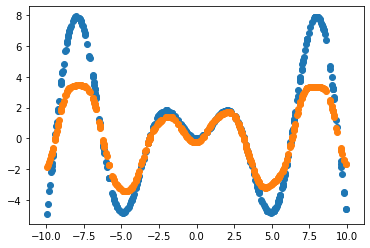

In [12]:
plt.scatter(sub_train_X[:,0], true_func(sub_train_X))
plt.scatter(sub_train_X[:,0], est_u)
plt.show()

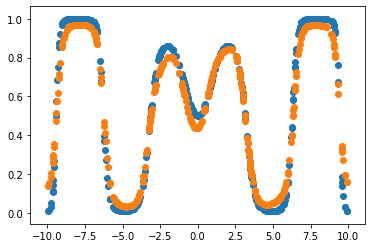

In [13]:
plt.scatter(sub_train_X[:,0], expit(true_func(sub_train_X)))
plt.scatter(sub_train_X[:,0], expit(est_u))
plt.show()